# Ripple 'Close' value prediction Using Pandas, Keras, math, numpy, matplotlib 

In [340]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM

## Data Function to Grab CSV and to drop all columns except 'Open','High' and 'Close'

In [341]:
def get_stock_data(coin_name, normalized=0):
    url="https://data.ripple.com/v2/exchanges/BTC+rvYAfWj5gh67oV6fW32ZzP3Aw4Eubs59B/XRP?interval=1day&format=csv&start=2016-12-01T00:00:00Z"
 #   url="http://www.google.com/finance/historical?q="+stock_name+"&startdate=Jul+12%2C+2013&enddate=Jul+11%2C+2017&num=30&ei=rCtlWZGSFN3KsQHwrqWQCw&output=csv"
#     url="http://www.google.com/finance/historical?q=%s&ei=u-lHWfGPNNWIsgHHqIqICw&output=csv" % stock_name 

    col_names = ["open","high","low","close","vwap","count","base_currency","base_issuer","base_volume","counter_currency","counter_issuer","counter_volume","open_time","close_time","start","buy_volume"]
   # col_names = ['Date','Open','High','Low','Close','Volume']
    
    
    #pandas read csv file from url provided 
    stocks = pd.read_csv(url, header=0, names=col_names) 
    #stocks = pd.read_json(url, typ='series')
  
    df = pd.DataFrame(stocks)
    #print "Series\n", df
    #0 open
    #1 high
    #2 low 
    #3 close
    #4 vwap
    #5 count
    #6 base_currency (BTC)
    #6 base_issuer
    #7 base_volume
    #8 counter_curency (xrp)
    #....
    
    df.drop(df.columns[[2,4,5,6,7,8,9,10,11,12,13,14,15]], axis=1, inplace=True) 
    return df

## Grab the Information From the CSV File

In [342]:
coin_name = 'Ripple'
df = get_stock_data(coin_name,0)
df.tail()

,open,high,close
195,10376.5500,12900.000,9452.6894
196,9387.1211,10061.375,9931.7234
197,9810.6048,10030.080,9939.3700
198,9962.1440,10305.850,10234.3670
199,10179.3830,10301.611,9569.3685


## Saving the data to a file for a future use

In [343]:
today = datetime.date.today()
file_name = coin_name+'_stock_%s.csv' % today
df.to_csv(file_name)

In [344]:
df['high'] = df['high'] / 1000 #* 10
df['open'] = df['open'] /1000 #* 10
df['close'] = df['close'] /1000 #* 10
df.head(5)

,open,high,close
0,111.09451,114.02509,113.89522
1,114.27913,120.26886,117.23008
2,117.14784,117.92453,117.63012
3,117.69847,119.39907,118.49610
4,118.54937,119.97630,117.58332


## Updated load_data function from lstm.py, configured to accept any amount of features.
## It is set to calculate the last feature as a result.

In [345]:
def load_data(stock, seq_len):
    amount_of_features = len(stock.columns)
    data = stock.as_matrix() #pd.DataFrame(stock)
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])

    result = np.array(result)
    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    x_train = train[:, :-1]
    y_train = train[:, -1][:,-1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1][:,-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return [x_train, y_train, x_test, y_test]


## Building model functions

In [346]:
def build_model(layers):
    model = Sequential()

    model.add(LSTM(
        input_dim=layers[0],
        output_dim=layers[1],
        return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(
        output_dim=layers[2]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop",metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

def build_model2(layers):
        d = 0.2
        model = Sequential()
        model.add(LSTM(128, input_shape=(layers[1], layers[0]), return_sequences=True))
        model.add(Dropout(d))
        model.add(LSTM(64, input_shape=(layers[1], layers[0]), return_sequences=False))
        model.add(Dropout(d))
        model.add(Dense(16, activation="relu", kernel_initializer="uniform"))        
        model.add(Dense(1, activation="relu", kernel_initializer="uniform"))
        model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
        return model

## Setting X and Y for training and testing

In [347]:
window = 5
X_train, y_train, X_test, y_test = load_data(df[::-1], window)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

('X_train', (175, 5, 3))
('y_train', (175,))
('X_test', (19, 5, 3))
('y_test', (19,))


## Loading the model sequence structure

In [348]:
# model = build_model([3,lag,1])
model = build_model2([3,window,1])

## Executing the model & RMS/RMSE results

In [349]:
model.fit(
    X_train,
    y_train,
    batch_size=512,
    nb_epoch=500, # was 500
    validation_split=0.1,
    verbose=0)

In [350]:
trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

Train Score: 81.12 MSE (9.01 RMSE)
Test Score: 2.86 MSE (1.69 RMSE)


In [351]:
print(X_test[-1])
diff=[]
ratio=[]
p = model.predict(X_test)
for u in range(len(y_test)):
    pr = p[u][0]
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))
    print(u, y_test[u], pr, (y_test[u]/pr)-1, abs(y_test[u]- pr))

[[ 113.80523  116.94555  106.91238]
 [ 117.61168  119.33074  113.38852]
 [ 118.54937  119.9763   117.58332]
 [ 117.69847  119.39907  118.4961 ]
 [ 117.14784  117.92453  117.63012]]
(0, 123.14988000000001, 125.71233, -0.020383411319503275, 2.5624460498046773)
(1, 120.48192999999999, 122.06984, -0.01300820484679388, 1.5879094775390712)
(2, 119.41847, 121.21902, -0.014853729959303674, 1.8005546582031258)
(3, 121.39905999999999, 122.70747, -0.010662807788323403, 1.3084061254882897)
(4, 118.44674000000001, 118.18301, 0.0022315058251247688, 0.26372608398438047)
(5, 115.39286, 115.28669, 0.00092092367229734684, 0.10617024169921763)
(6, 116.74575, 117.59241, -0.0071999310714956355, 0.84665722656249898)
(7, 114.21171000000001, 114.52197, -0.0027091311852944777, 0.31025502685545803)
(8, 115.13284, 114.64774, 0.0042312602318423931, 0.48510440429687662)
(9, 113.49925, 112.83398, 0.0058959685655433081, 0.66526562500000352)
(10, 114.21205999999999, 113.59454, 0.0054362137039785097, 0.617524172363275

## Predictions vs Real results

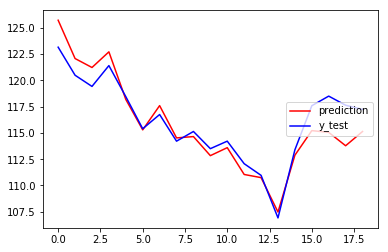

In [352]:
import matplotlib.pyplot as plt2

plt2.plot(p,color='red', label='prediction')
plt2.plot(y_test,color='blue', label='y_test')
plt2.legend(loc='center right')
plt2.show()